In [2]:
from google.colab import files
uploaded = files.upload()

Saving training.data.npz to training.data.npz


In [3]:
!ls

sample_data  training.data.npz


In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=d6527c939fc9fca7ae8ec63183ff5743e80c3063d40a70a46b43935644797dce
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 183.8 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [5]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import preprocessing
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from random import shuffle
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [6]:
data = np.load('training.data.npz')
#s12mat,s21mat,sNomat,s12pos,s21pos,sNopos,s12_target,s21_target,sNo_target = [data[i] for i in ['s12mat', 's21mat', 'sNomat', 's12pos', 's21pos', 'sNopos', 's12_target', 's21_target', 'sNo_target']]

xdata = data['x']
ytarget = data['target']
s = xdata.shape

xdata,ytarget = np.reshape(xdata, newshape=(s[0], s[1], s[2], 1)), np.reshape(ytarget, newshape=(s[0], s[1], s[2], 1))

xdata_train,ytarget_train = xdata[1000:], ytarget[1000:]
xdata_test, ytarget_test  = xdata[:1000], ytarget[:1000] 

xdata_test.shape

(1000, 48, 128, 1)

In [38]:
def relu_clipped(x):
    return K.relu(x, max_value=1)

inputs = Input((s[1],s[2],1))
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool3)
conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool4)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv6)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv7)

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv8)

up9 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge9)
conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
conv10 = Conv2D(1, 1, activation = relu_clipped)(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 48, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_241 (Conv2D)             (None, 48, 128, 32)  320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 48, 128, 32)  9248        conv2d_241[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 24, 64, 32)   0           conv2d_242[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [39]:
model.fit(xdata_train, ytarget_train, batch_size=64,
          epochs=25, verbose=1,
          validation_data=(xdata_test, ytarget_test))

Train on 19000 samples, validate on 1000 samples
Epoch 1/25
19000/19000 [==============================] - 35s 2ms/step - loss: 0.3902 - acc: 0.7636 - val_loss: 0.3199 - val_acc: 0.8200
Epoch 2/25
19000/19000 [==============================] - 26s 1ms/step - loss: 0.3664 - acc: 0.7742 - val_loss: 0.3490 - val_acc: 0.7734
Epoch 3/25
19000/19000 [==============================] - 25s 1ms/step - loss: 0.3463 - acc: 0.7654 - val_loss: 0.3422 - val_acc: 0.7808
Epoch 4/25
19000/19000 [==============================] - 26s 1ms/step - loss: 0.3773 - acc: 0.7652 - val_loss: 0.3456 - val_acc: 0.7707
Epoch 5/25
19000/19000 [==============================] - 26s 1ms/step - loss: 0.3453 - acc: 0.7700 - val_loss: 0.3442 - val_acc: 0.7727
Epoch 6/25
19000/19000 [==============================] - 25s 1ms/step - loss: 0.3435 - acc: 0.7743 - val_loss: 0.3413 - val_acc: 0.7771
Epoch 7/25
19000/19000 [==============================] - 25s 1ms/step - loss: 0.3393 - acc: 0.7793 - val_loss: 0.3371 - val_acc:

In [0]:
p = model.predict(xdata_test)

In [41]:
roundp = np.rint(p)
err = np.mean(ytarget_test-roundp)
err

-0.015800944

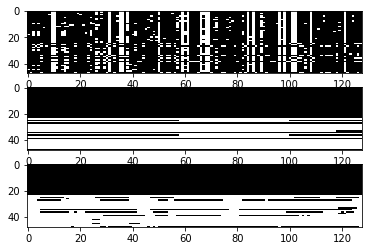

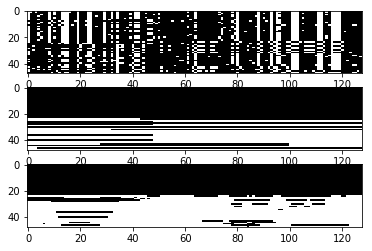

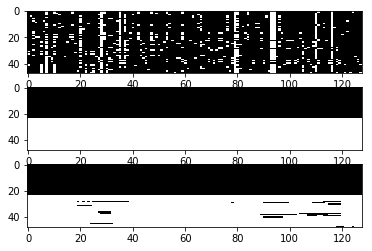

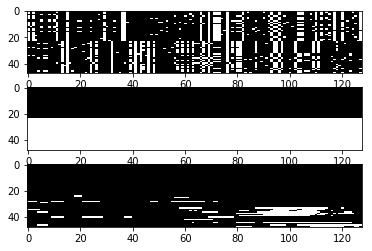

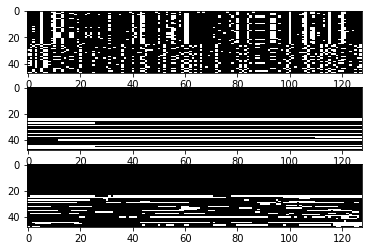

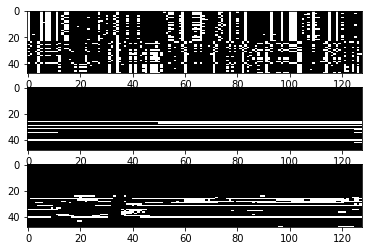

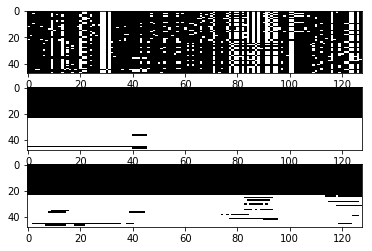

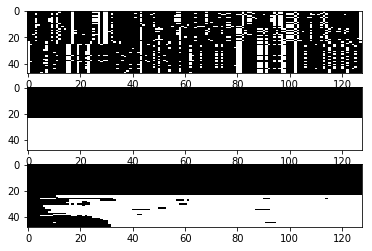

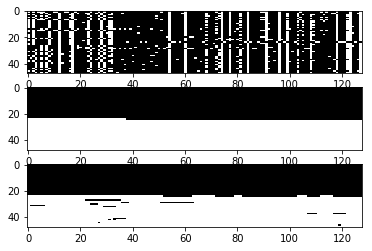

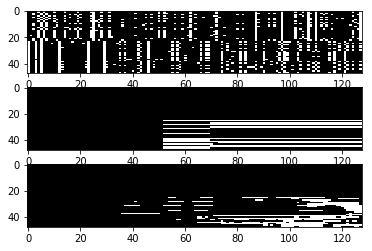

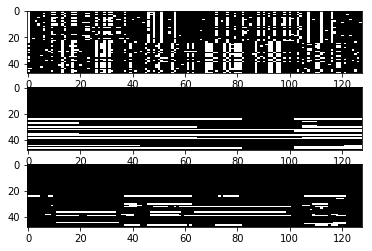

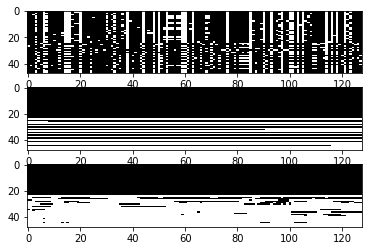

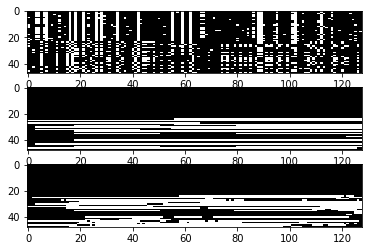

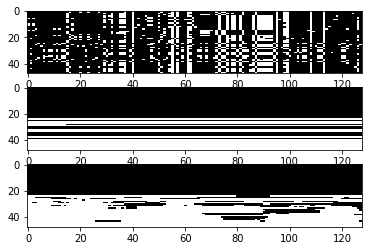

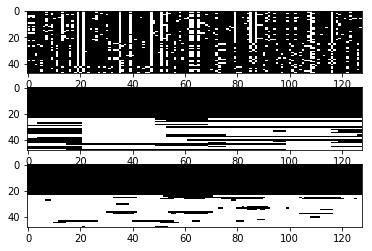

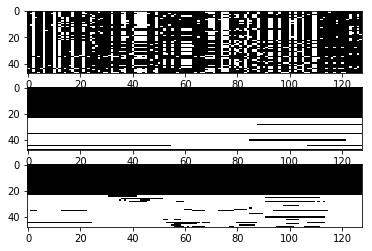

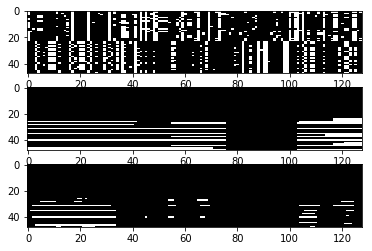

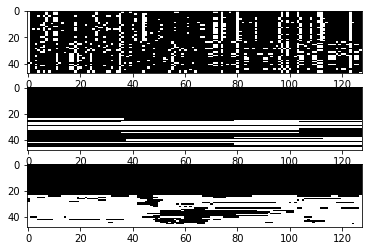

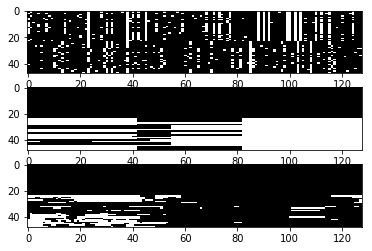

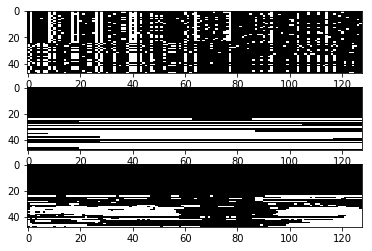

In [42]:
for i in range(20):
  plt.subplot(3,1,1)
  plt.imshow(np.reshape(xdata_test[i], (48, 128)), aspect=.5, cmap='bone')

  plt.subplot(3,1,2)
  plt.imshow(np.reshape(ytarget_test[i], (48, 128)), aspect=.5, cmap='bone')

  plt.subplot(3,1,3)
  plt.imshow(np.rint(np.reshape(p[i],  (48, 128))), aspect=.5, cmap='bone')
  plt.show()